<a href="https://colab.research.google.com/github/jack-baxter/AAI521-G6-Final/blob/main/Group_6_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><center>AAI-521 Final Project
<br><center>Solar Panel Defect Detection
<br><center>Group 6
<br><center>Fall 2025, Dr. Albuyeh
<br><center>Jamshed Nabizada, Jack Baxter, Naima Botros


Install dependencies


In [1]:
# Install necessary deep learning and utility libraries
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib seaborn Pillow


Imports & Google Drive Mount

In [2]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

print("Environment setup complete. Drive mounted.")


Mounted at /content/drive
Environment setup complete. Drive mounted.


Dataset Path Configuration

In [3]:
# Base directory for the Kaggle ELPV folder structure
# (train/ test/ valid/ folders already exist)
BASE_DIR = "/content/drive/MyDrive/ELPV_SOLAR_DATA/"

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError("BASE_DIR does not exist. Check your Google Drive path.")

print("BASE_DIR:", BASE_DIR)


BASE_DIR: /content/drive/MyDrive/ELPV_SOLAR_DATA/


Load and Convert Label Files → Binary Classification

In [4]:
def create_binary_classification_labels(root_dir):
    """
    Scans train/test/valid folders and creates a dataframe:
    - image_path
    - label (0 = no defect, 1 = defect)

    A .txt label file with content indicates a defect.
    Empty or missing file = non-defective.
    """
    data_list = []

    for split_dir in ["train", "test", "valid"]:
        img_dir = os.path.join(root_dir, split_dir, "images")
        lbl_dir = os.path.join(root_dir, split_dir, "labels")

        if not os.path.isdir(img_dir):
            continue

        for img_name in os.listdir(img_dir):
            name, ext = os.path.splitext(img_name)
            if ext.lower() not in [".png", ".jpg", ".jpeg"]:
                continue

            img_path = os.path.join(img_dir, img_name)
            txt_path = os.path.join(lbl_dir, name + ".txt")

            # Binary label logic
            label = 1 if (os.path.exists(txt_path) and os.path.getsize(txt_path) > 0) else 0

            data_list.append({
                "image_path": img_path,
                "label": label
            })

    return pd.DataFrame(data_list)


df_full = create_binary_classification_labels(BASE_DIR)

if df_full.empty:
    raise SystemExit("ERROR: No images found. Check BASE_DIR path.")

print("Total images found:", len(df_full))
print(df_full.head())
print("\nClass distribution:\n", df_full["label"].value_counts())


Total images found: 7435
                                          image_path  label
0  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
1  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
2  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
3  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1
4  /content/drive/MyDrive/ELPV_SOLAR_DATA/train/i...      1

Class distribution:
 label
1    7332
0     103
Name: count, dtype: int64


Stratified Train/Val/Test Split (80/10/10)

In [5]:
df_train, df_temp = train_test_split(
    df_full, test_size=0.20, stratify=df_full["label"], random_state=42
)

df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp["label"], random_state=42
)

print("\nFinal Split Sizes:")
print("Train:", len(df_train))
print("Val:  ", len(df_val))
print("Test: ", len(df_test))



Final Split Sizes:
Train: 5948
Val:   743
Test:  744


EDA: Class Distribution Visualization

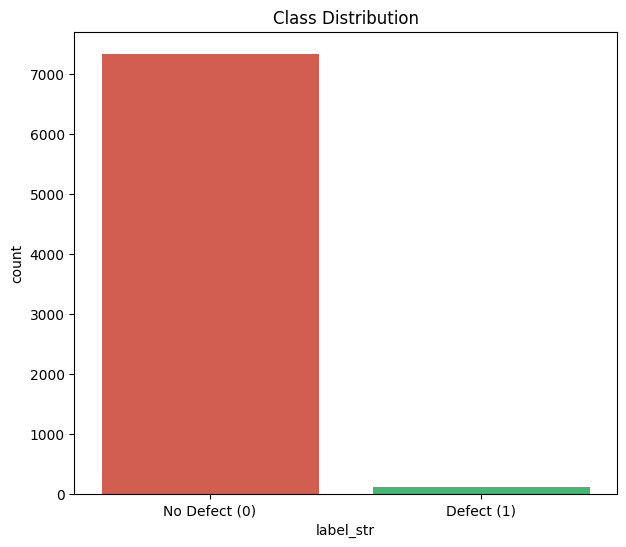

In [6]:
df_full["label_str"] = df_full["label"].astype(str)

plt.figure(figsize=(7,6))
sns.countplot(
    x="label_str",
    hue="label_str",
    data=df_full,
    palette={"0": "#2ecc71", "1": "#e74c3c"}
)
plt.xticks([0, 1], ["No Defect (0)", "Defect (1)"])
plt.title("Class Distribution")
plt.show()


Visual Sample Check

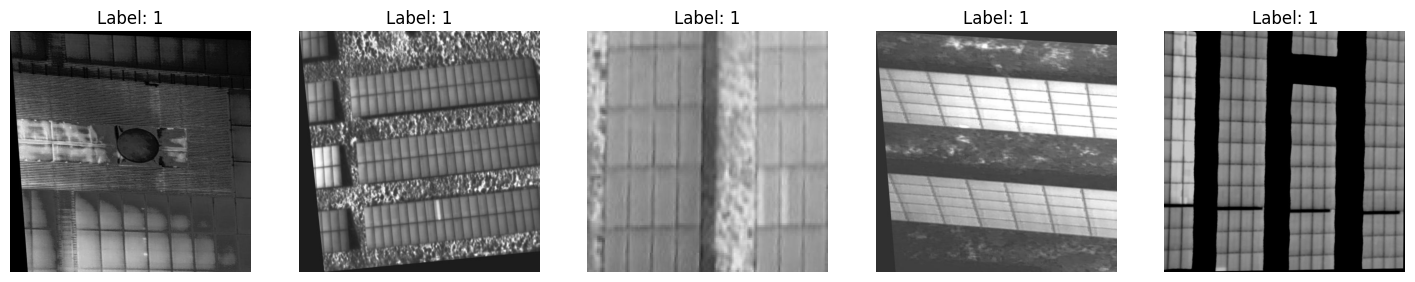

In [7]:
def show_samples(df, n=5):
    samples = df.sample(n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(18,5))

    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(row["image_path"]).convert("RGB")
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {row['label']}")
            axes[i].axis("off")
        except Exception as e:
            axes[i].set_title(f"Error loading image:\n{e}", color='red')
            axes[i].axis("off")

    plt.show()

show_samples(df_train, n=5)


Image Transforms

In [8]:
# Standard input size for ResNet
image_size = 256

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


Custom Dataset Class

In [9]:
class PVPanelDataset(Dataset):
    """Dataset that loads images from a dataframe of file paths."""

    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except:
            return None  # corrupt image fallback

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(row["label"], dtype=torch.long)
        return img, label


Custom Collate Function

In [10]:
def collate_remove_none(batch):
    """
    Removes None samples from batch (corrupt images).
    Returns None if batch becomes empty.
    """
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


DataLoader Setup

In [11]:
batch_size = 32
num_workers = 2   # adjust to 1 if Colab crashes

train_loader = DataLoader(
    PVPanelDataset(df_train, train_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_remove_none
)

val_loader = DataLoader(
    PVPanelDataset(df_val, test_transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_remove_none
)

test_loader = DataLoader(
    PVPanelDataset(df_test, test_transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_remove_none
)

print("Dataloaders ready.")


Dataloaders ready.


ResNet18 Initialization

In [12]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_resnet18(num_classes=2, freeze=True):
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)

    if freeze:
        for p in model.parameters():
            p.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

model = initialize_resnet18()
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Class Weight Calculation

In [13]:
counts = df_full["label"].value_counts()
minority = counts.get(0, 1)
majority = counts.get(1, 1)

# weight = inverse frequency
weight_for_0 = majority / minority
weight_for_1 = 1.0

class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)

print("Class weights:", class_weights)


Class weights: tensor([71.1845,  1.0000])
